# *RECONSTRUCTION SKILL EVALUATION*

The Analog Method (AM) is a statistical downscaling method very well suited for reconstruction of climatic time series. The reconstruction can reproduce the climatic characteristics of the local phenomena a certain region, based on the relationship between the large scale and the observed local weather patterns.

To validate the quality of the reconstructions is the important to look how the climatic characteristics are reproduced.

This notebook is an example of a fairly complete skill evaluation of the reconstructions and a comparision with the skill of the reanalysis. It contains the following elements:

- Time series skill (Bias, Heidke Skill Score, SSMSE and Taylor diagrams) for daily, monthly and yearly series
- Seasonality
- Equality of distributions
- Daily indices (Days above zero degree, days of precipitation above threshold)

In [1]:
import re
import os
import datetime
import itertools
import rascal.utils
import rascal.analogs
import rascal.indices
import rascal.analysis

import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from scipy.stats import percentileofscore

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
initial_year = 2007
final_year = 2012

station_to_validate = "St02"
variable_to_validate = "TMIN"

    
if variable_to_validate == "PCP":
    threshold=1
    inverse=False
elif variable_to_validate in ["TMAX", "TMIN", "TMEAN"]:
    threshold=0
    inverse=True

In [3]:
# How to group the data when resampling the daily data to monthly or yearly
groupings = {
    "TMEAN": "mean",
    "TMAX": "mean",
    "TMIN": "mean",
    "PCP": "sum"
}

reanalysis_variables = {
    "TMEAN": ["SURF_T"],
    "TMAX": ["SURF_T"],
    "TMIN": ["SURF_T"],
    "PCP": ["SURF_PCP"]
}

# How to group the data to daily resolution
reanalysis_grouping = {
    "TMEAN": "1D_mean",
    "TMAX": "1D_max",
    "TMIN": "1D_min",
    "PCP": "1D_sum"
}

units = {
    "TMEAN": "[$^\circ$C]",
    "TMAX": "[$^\circ$C]",
    "TMIN": "[$^\circ$C]",
    "PCP": "[mm]"
}

if variable_to_validate == "PCP":
    hydroyear=True
else: 
    hydroyear=False
    
ensemble_variables = ["PCP"]

### Paths

In [4]:
if variable_to_validate == "PCP":
    predictor = "SURF_71.162andSURF_72.162-SURF_71.162andSURF_72.162-1"
elif variable_to_validate in ["TMAX", "TMIN", "TMEAN"]:
    predictor = "925_Z-SURF_T-1"

observations_directory = "./data/observations/"
reanalysis_directory = "./data/reanalysis/REA02/"
reconstructions_directory = "/".join([".", "output", variable_to_validate, predictor]) + "/"

# 0) LOAD DATA 

To evaluate the skill of the reconstructions the following data is needed:
- Observational data: To compare the reconstructions with the original data.
- Reconstructions: All the different reconstructions for the same variable in the same time, to compare how different methods perform in different tasks.
- Reanalysis data: To compare the added value of using RASCAL instead of using only the reanalysis.

## 0.1) STATION DATA

In [5]:
station = rascal.analogs.Station(path= observations_directory + station_to_validate + '/')
station_daily = station.get_data(variable=variable_to_validate, skipna=False)
station_daily.index.name = "time"

## 0.2) REANALYSIS DATA

Load the reanalysis or reference model data. If the variable is part of an ensemble, all the members of the ensemble are loaded in a single dataframe as "'variable name'_'member number'". Once the data is extracted in the gridpoint of the station, a .csv file is saved, to save computation time in future runs.

In [6]:
reanalysis_data_name = "_".join([station.name, variable_to_validate, "ERA20C.csv"])
reanalysis_series_filepath = "/".join([reanalysis_directory, "series", reanalysis_data_name])
reanalysis_original_path = reanalysis_directory

# Load the .csv file if it already exists
if os.path.exists(reanalysis_series_filepath):
    reanalysis_data = pd.read_csv(reanalysis_series_filepath, index_col=0)
    reanalysis_data.index = pd.to_datetime(reanalysis_data.index)
    reanalysis_data.index.name = "time"
    
# If it does not, extract the data in the gridpoint from the original files
else:
    if variable_to_validate in ensemble_variables:
        reanalysis_data = []
        for ensemble_member in range(reanalysis_ensemble_members):
            ensemble_member_data = rascal.analysis.get_reanalysis_in_gridpoint(
                reanalysis_original_path,
                initial_year=initial_year,
                final_year=final_year,
                variable=reanalysis_variables[variable_to_validate],
                grid_point={"lat": station.latitude, "lon": station.longitude},
                file_format=".nc",
                grouping=reanalysis_grouping[variable_to_validate],
                ensemble_member=ensemble_member    
            )
            reanalysis_data.append(ensemble_member_data)
        reanalysis_data = pd.concat(reanalysis_data, axis=1)
        
    else:
        reanalysis_data = rascal.analysis.get_reanalysis_in_gridpoint(
            reanalysis_original_path,
            initial_year=initial_year,
            final_year=final_year,
            variable=reanalysis_variables[variable_to_validate],
            grid_point={"lat": station.latitude, "lon": station.longitude},
            file_format=".nc",
            grouping=reanalysis_grouping[variable_to_validate],
            ensemble_member=None 
        )

    reanalysis_data.to_csv(reanalysis_data_name)


Function 'get_files' executed in 0.0005s
Function 'open_data' executed in 5.8075s


In [7]:
reanalysis_data

,SURF_T
time,
2007-01-01,278.214111
2007-01-02,275.011719
2007-01-03,274.239258
2007-01-04,272.773682
2007-01-05,275.271729
...,...
2012-12-27,272.018311
2012-12-28,273.333984
2012-12-29,272.633057


In [8]:
reanalysis_daily = rascal.analysis.get_reanalysis_ensemble(
    reanalysis_data, 
    variable_to_validate=variable_to_validate,
    freq="1D", 
    grouping=groupings[variable_to_validate]
)


Index(['SURF_T'], dtype='object')


In [9]:
reanalysis_daily

,SURF_T
time,
2007-01-01,278.214111
2007-01-02,275.011719
2007-01-03,274.239258
2007-01-04,272.773682
2007-01-05,275.271729
...,...
2012-12-27,272.018311
2012-12-28,273.333984
2012-12-29,272.633057


In [10]:
reanalysis_daily.columns = [
    c.replace(reanalysis_variables[variable_to_validate][0], variable_to_validate) for c in reanalysis_daily.columns
]        
    
# Change units
# Kelvin to Celsius
if variable_to_validate in ["TMAX", "TMIN", "TMEAN", "TMPA"]:
    reanalysis_daily = reanalysis_daily - 273.1
# m to mm
elif variable_to_validate == "PCP":
    reanalysis_daily = reanalysis_daily * 1000

In [11]:
reanalysis_daily

,TMIN
time,
2007-01-01,5.114105
2007-01-02,1.911713
2007-01-03,1.139252
2007-01-04,-0.326324
2007-01-05,2.171722
...,...
2012-12-27,-1.081696
2012-12-28,0.233978
2012-12-29,-0.466949


## 0.3) RECONSTRUCTIONS DATA

In [12]:
reconstructions_daily = rascal.analysis.get_reconstruction_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1D',
    grouping=groupings[variable_to_validate]
)

## 0.4) DAILY, MONTHLY AND YEARLY FREQUENCY

In [13]:
# Daily data 
rskill = rascal.analysis.RSkill(
    observations=station_daily,
    reconstructions=reconstructions_daily,
    reanalysis=reanalysis_daily
)

# Monthly data
rskill_1m = rskill.resample(freq="1m", grouping=groupings[variable_to_validate], hydroyear=hydroyear, skipna=False)

# Yearly data
rskill_1y = rskill.resample(freq="1Y", grouping=groupings[variable_to_validate], hydroyear=hydroyear, skipna=True)

In [14]:
rskill_1y.data

,TMIN_observation,TMIN_reanalysis,TMIN_average02_reconstructions,TMIN_average05_reconstructions,TMIN_average10_reconstructions,TMIN_closest_reconstructions,TMIN_quantilemap020_reconstructions,TMIN_quantilemap050_reconstructions,TMIN_quantilemap100_reconstructions
time,,,,,,,,,
2007-12-31,7.196829,6.229733,5.105769,5.192096,5.282864,5.143808,4.597973,4.503863,4.404219
2008-12-31,4.951943,6.517770,4.845274,4.986873,5.055798,4.700683,4.660082,4.541475,4.581339
2009-12-31,6.794828,7.142197,5.273842,5.241469,5.274124,5.317973,5.012192,5.132986,5.167151
2010-12-31,3.704557,6.479615,3.888666,4.069876,4.230402,3.788822,4.334164,4.342822,4.390219
2011-12-31,2.987715,7.562567,5.308766,5.334107,5.487759,5.268164,5.895096,5.926822,5.854000
2012-12-31,4.840000,6.580145,NaN,NaN,NaN,NaN,4.579235,4.496557,4.463306


# 1) TIME SERIES

## 1.1) Daily time series

In [15]:
initial_date = datetime.datetime(2007, 1, 1)
final_date = datetime.datetime(2012, 12, 31)

In [16]:
rskill.reanalysis.columns

Index(['TMIN_reanalysis'], dtype='object')

TMIN_reanalysis


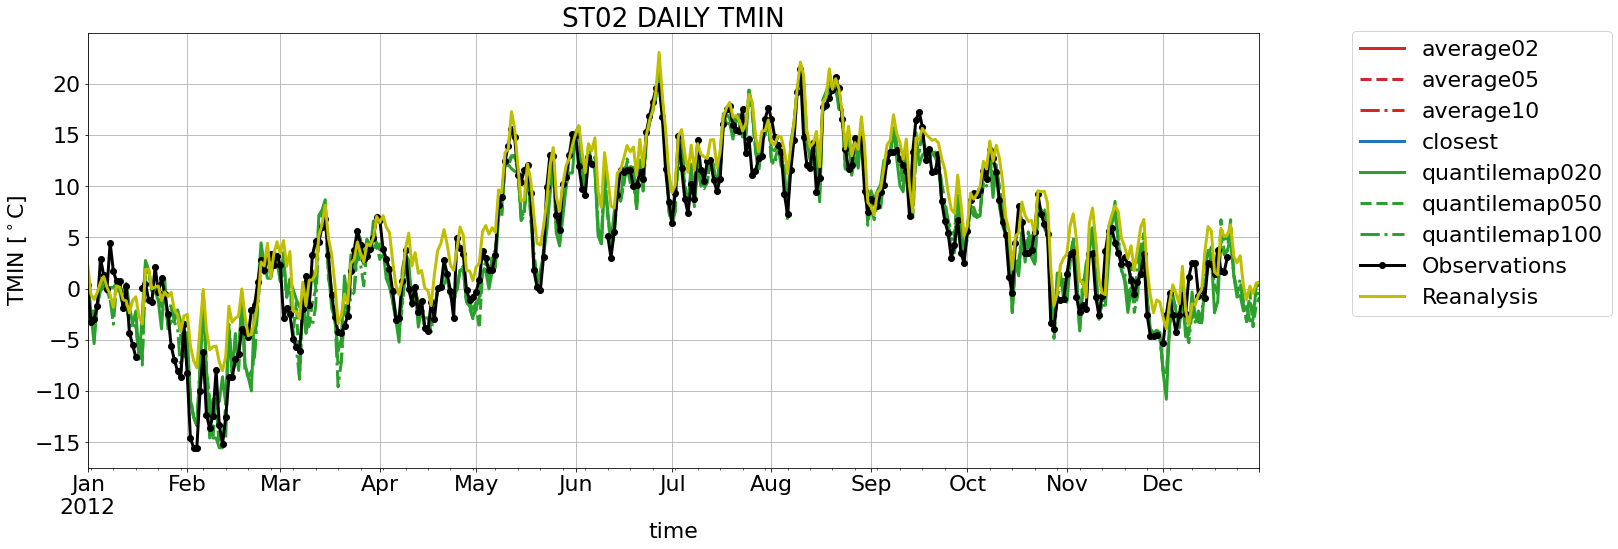

In [17]:
fig, ax = rskill.plotseries(start=datetime.datetime(2012, 1, 1), end=datetime.datetime(2012, 12, 31))
# fig, ax = rskill.plotseries(start=initial_date, end=final_date)
ax.set_title(station.name.upper() + " DAILY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.show()

## 1.2) Daily skill table

In [18]:
_, daily_skill = rskill.skill(threshold=1)

In [19]:
daily_skill

,bias,rmse,r2,std,bs
TMIN_average02_reconstructions,-0.296003,4.541956,0.785609,6.51227,0.194301
TMIN_average05_reconstructions,-0.374487,4.139188,0.81916,6.239377,0.178756
TMIN_average10_reconstructions,-0.480601,4.039664,0.827861,6.080552,0.174870
TMIN_closest_reconstructions,-0.230233,5.102914,0.741474,6.919903,0.220855
TMIN_quantilemap020_reconstructions,-0.235053,2.554899,0.936013,6.809827,0.112988
TMIN_quantilemap050_reconstructions,-0.209578,2.508705,0.938661,6.916876,0.112988
TMIN_quantilemap100_reconstructions,-0.191426,2.512661,0.938579,6.935953,0.108765
TMIN_reanalysis,-2.111855,3.392127,0.930679,6.32818,0.164731


## 1.3) Daily Taylor diagram

(<Figure size 360x360 with 1 Axes>,
 <rascal.analysis.TaylorDiagram at 0x7f97848ecf40>)

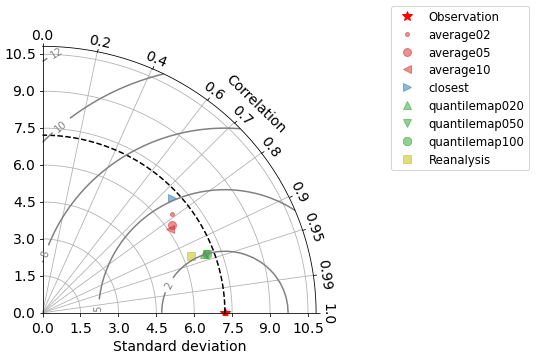

In [20]:
rskill.taylor()

## 1.4) Monthly time series

TMIN_reanalysis


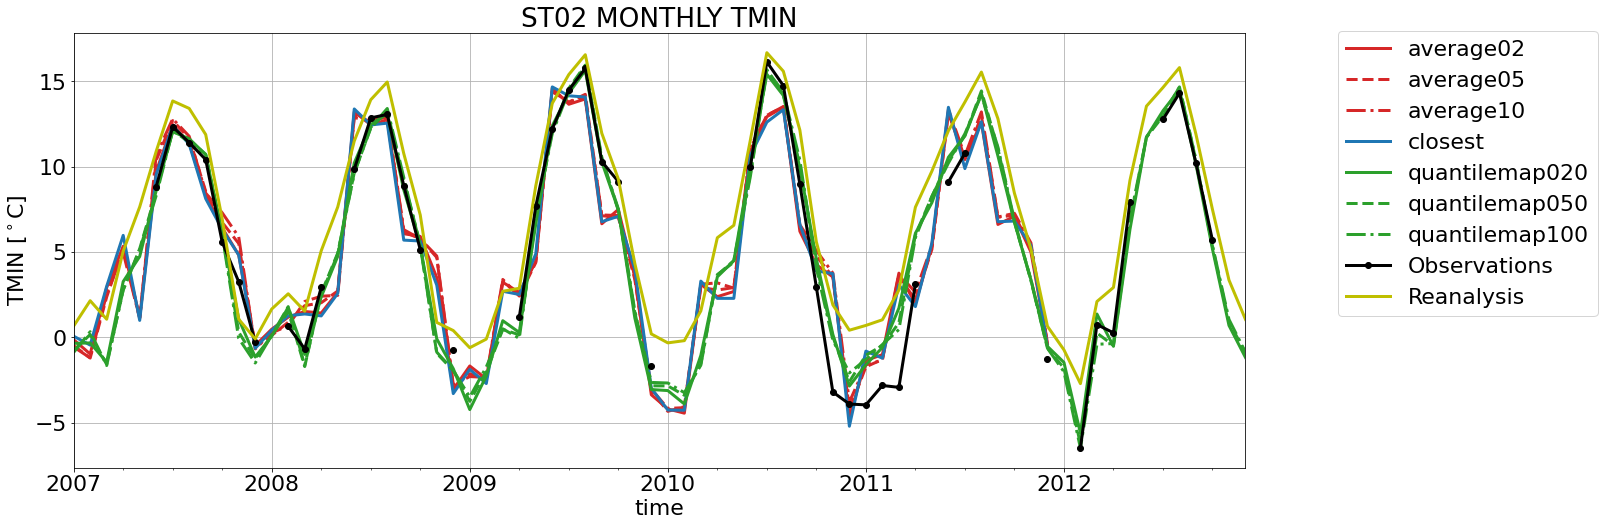

In [21]:
fig, ax = rskill_1m.plotseries(start=datetime.datetime(2007, 1, 1), end=datetime.datetime(2012, 12, 31))
ax.set_title(station.name.upper() + " MONTHLY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.show()

## 1.5) Monthly skill table

In [22]:
_, monthly_skill = rskill_1m.skill()

In [23]:
monthly_skill

,bias,rmse,r2,std,bs
TMIN_average02_reconstructions,-0.191351,2.427372,0.920719,5.374454,5.892137
TMIN_average05_reconstructions,-0.300332,2.36789,0.925555,5.424474,5.606904
TMIN_average10_reconstructions,-0.417643,2.428255,0.922704,5.423373,5.896421
TMIN_closest_reconstructions,-0.117877,2.431846,0.920034,5.390236,5.913873
TMIN_quantilemap020_reconstructions,-0.262166,1.337691,0.978395,5.86918,1.789416
TMIN_quantilemap050_reconstructions,-0.199296,1.303608,0.978825,5.930099,1.699395
TMIN_quantilemap100_reconstructions,-0.163827,1.296705,0.978825,5.929551,1.681443
TMIN_reanalysis,-2.020189,2.451147,0.977509,5.599096,6.008122


## 1.6) Monthly Taylor diagram

'\nplt.savefig(\n    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/taylor_monthly_" \n    + variable_to_validate + "_" + station_to_validate\n    + ".png",\n    bbox_inches = \'tight\'\n)\n'

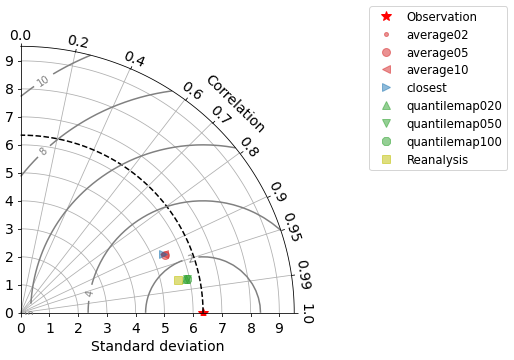

In [24]:
letter = {
    "segovia": "(a) ",
    "navacerrada": "(d) ",
    "colmenar": "(g) ",
    "retiro": "(j) "
}


fig, diag = rskill_1m.taylor()
#fig.suptitle(letter[station_to_validate] + station_to_validate + " monthly " + variable_to_validate)
"""
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/taylor_monthly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png",
    bbox_inches = 'tight'
)
"""

## 1.7) Yearly time series

TMIN_reanalysis


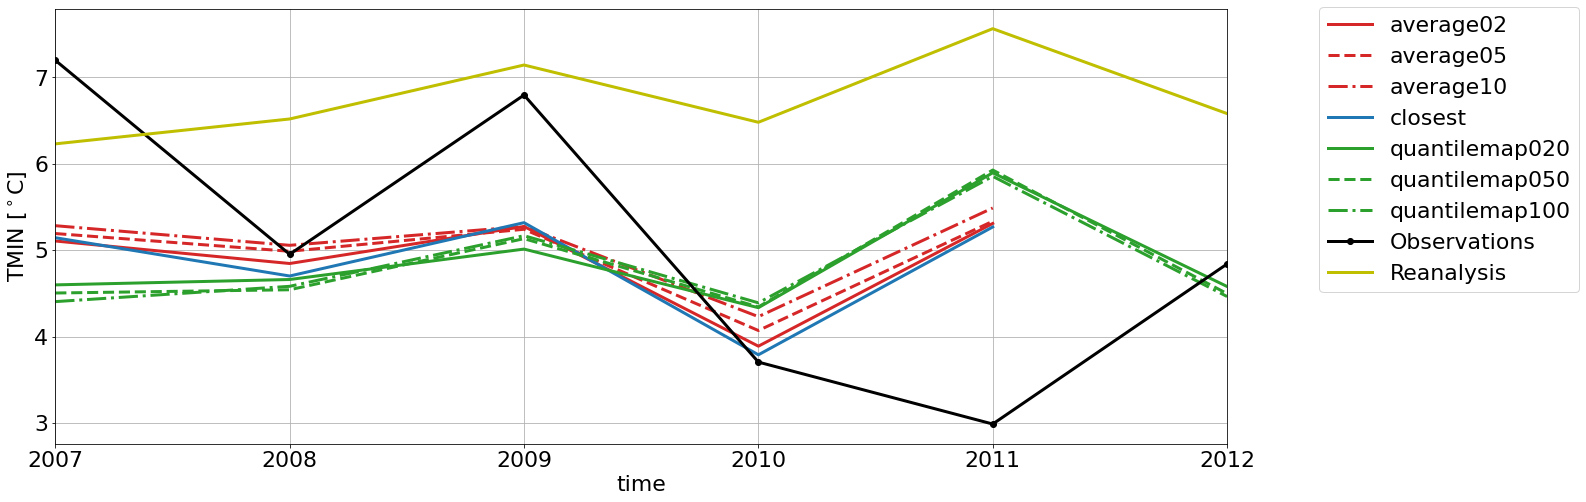

In [25]:

#fig, ax = rskill_1y.plotseries(start=initial_date, end=final_date, methods=[best_method[station_to_validate]])
fig, ax = rskill_1y.plotseries(start=initial_date, end=final_date)

#ax.set_title(letter[station_to_validate] + station.name + " yearly " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
"""
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/series_yearly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)
"""
plt.show()

## 1.8) Yearly skill table

In [26]:
_, yearly_skill = rskill_1y.skill()

In [27]:
yearly_skill

,bias,rmse,r2,std,bs
TMIN_average02_reconstructions,0.242711,1.556822,0.374184,0.52417,2.423696
TMIN_average05_reconstructions,0.16229,1.553841,0.369266,0.46173,2.414423
TMIN_average10_reconstructions,0.060985,1.581981,0.297957,0.439671,2.502663
TMIN_closest_reconstructions,0.283284,1.527526,0.429777,0.570682,2.333335
TMIN_quantilemap020_reconstructions,0.232855,1.776433,-0.354894,0.509484,3.155716
TMIN_quantilemap050_reconstructions,0.255224,1.795641,-0.334207,0.552682,3.224325
TMIN_quantilemap100_reconstructions,0.269273,1.798748,-0.356678,0.537099,3.235495
TMIN_reanalysis,-1.672693,2.420953,-0.408103,0.454721,5.861013


## 1.9) Yearly Taylor diagram

'\nfig.suptitle(letter[station_to_validate] + station_to_validate + " yearly " + variable_to_validate)\n\nplt.savefig(\n    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/taylor_yearly_" \n    + variable_to_validate + "_" + station_to_validate\n    + ".png"\n    , bbox_inches = \'tight\'\n)\n'

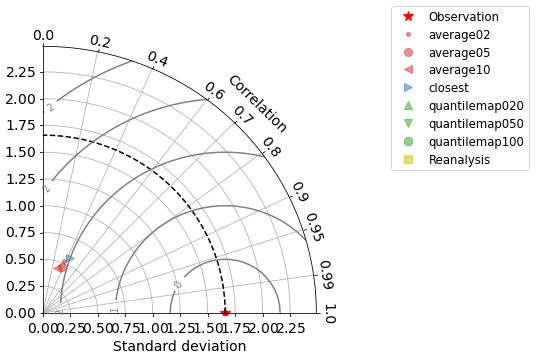

In [28]:
letter = {
    "segovia": "(b) ",
    "navacerrada": "(e) ",
    "colmenar": "(h) ",
    "retiro": "(k) "
}


fig, ax = rskill_1y.taylor()
"""
fig.suptitle(letter[station_to_validate] + station_to_validate + " yearly " + variable_to_validate)

plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/taylor_yearly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)
"""

# 2) SEASONALITY

## 2.1) Variable Annual Cycle

'\nplt.savefig(\n    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/cycle_var_" \n    + variable_to_validate + "_" + station_to_validate\n    + ".png"\n    , bbox_inches = \'tight\'\n)\n'

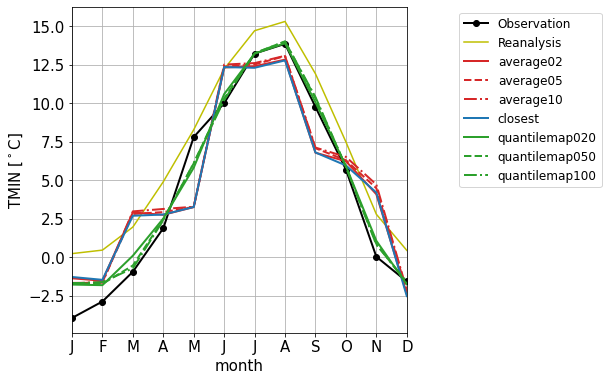

In [29]:
letter = {
    "segovia": "(a) ",
    "navacerrada": "(b) ",
    "colmenar": "(c) ",
    "retiro": "(d) "
}




fig, ax = rskill_1m.annual_cycle(grouping="mean")
ax.set_xlabel("month")
#ax.set_title(letter[station_to_validate] + station_to_validate + " " + variable_to_validate + " annual cycle")
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
"""
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/cycle_var_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)
"""

## 2.2) Variable Standard Deviation Annual Cycle

'\nplt.savefig(\n    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/cycle_std_" \n    + variable_to_validate + "_" + station_to_validate\n    + ".png"\n    , bbox_inches = \'tight\'\n)\n'

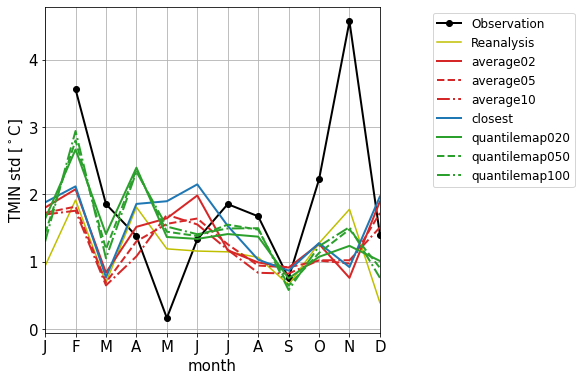

In [30]:
letter = {
    "segovia": "(e) ",
    "navacerrada": "(f) ",
    "colmenar": "(g) ",
    "retiro": "(h) "
}




fig, ax = rskill_1m.annual_cycle(grouping="std")
ax.set_xlabel("month")
#ax.set_title(letter[station_to_validate] + station_to_validate + " " + variable_to_validate + " std annual cycle")
ax.set_ylabel(variable_to_validate + " std " + units[variable_to_validate])
"""
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/cycle_std_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)
"""

# 3) DISTRIBUTIONS

## 3.1) Daily Quantile-Quantile Diagram

'\nplt.savefig(\n    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/qq_" \n    + variable_to_validate + "_" + station_to_validate\n    + ".png"\n    , bbox_inches = \'tight\'\n)\n'

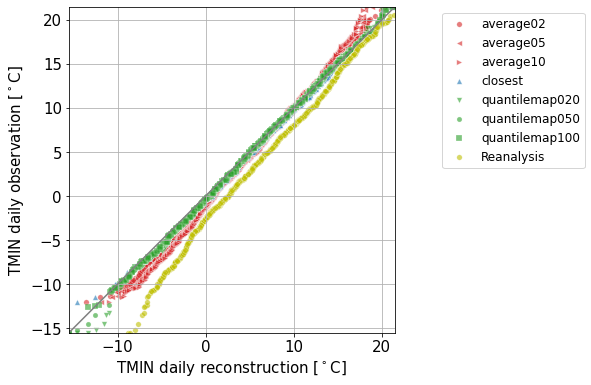

In [31]:
if variable_to_validate == "PCP":
    letter = {
        "segovia": "(a) ",
        "navacerrada": "(b) ",
        "colmenar": "(c) ",
        "retiro": "(d) "
    }
elif variable_to_validate == "TMAX":
    letter = {
        "segovia": "(e) ",
        "navacerrada": "(f) ",
        "colmenar": "(g) ",
        "retiro": "(h) "
    }
elif variable_to_validate == "TMIN":
    letter = {
        "segovia": "(i) ",
        "navacerrada": "(j) ",
        "colmenar": "(k) ",
        "retiro": "(l) "
    }


fig, ax = rskill.qqplot()
#ax.set_title(letter[station_to_validate] + "Quantile-Quantile of " + station_to_validate + " " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " daily observation " + units[variable_to_validate])
ax.set_xlabel(variable_to_validate + " daily reconstruction " + units[variable_to_validate])
"""
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/qq_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)
"""

# 4) INDICES

In [32]:
index_name = {
    "fd": "frost days  ($T_{min}$ < 0$^\circ$C)",
    "su": "summer days ($T_{max}$ > 25$^\circ$C)",
    "id": "icing days ($T_{max}$ < 0$^\circ$C)",
    "tr": "tropical nigths ($T_{min}$ > 20$^\circ$C)",
    "r10mm": "R10mm (PCP $\geq$ 10 mm)",
    "r20mm": "R20mm (PCP $\geq$ 20 mm)",
    "rnnmm": "R1mm (PCP $\geq$ 1 mm)",
    "cdd": "consecutive dry days",
    "cwd": "consecutive wet days",
}

In [33]:
station_daily_thr = rascal.indices.get_days_above_threshold(
    station_daily, 
    threshold=threshold, 
    inverse=inverse
)
reconstructions_daily_thr = rascal.indices.get_days_above_threshold(
    reconstructions_daily, 
    threshold=threshold, 
    inverse=inverse
)
reanalysis_daily_thr = rascal.indices.get_days_above_threshold(
    reanalysis_daily, 
    threshold=threshold, 
    inverse=inverse
)


# Daily data 
thrskill = rascal.analysis.RSkill(
    observations=station_daily_thr,
    reconstructions=reconstructions_daily_thr,
    reanalysis=reanalysis_daily_thr
)

# Monthly data
thrskill_1m = thrskill.resample(freq="1m", grouping="sum", hydroyear=hydroyear, skipna=False)

# Yearly data
thrskill_1y = thrskill.resample(freq="1Y", grouping="sum", hydroyear=hydroyear, skipna=False)

TMIN_reanalysis


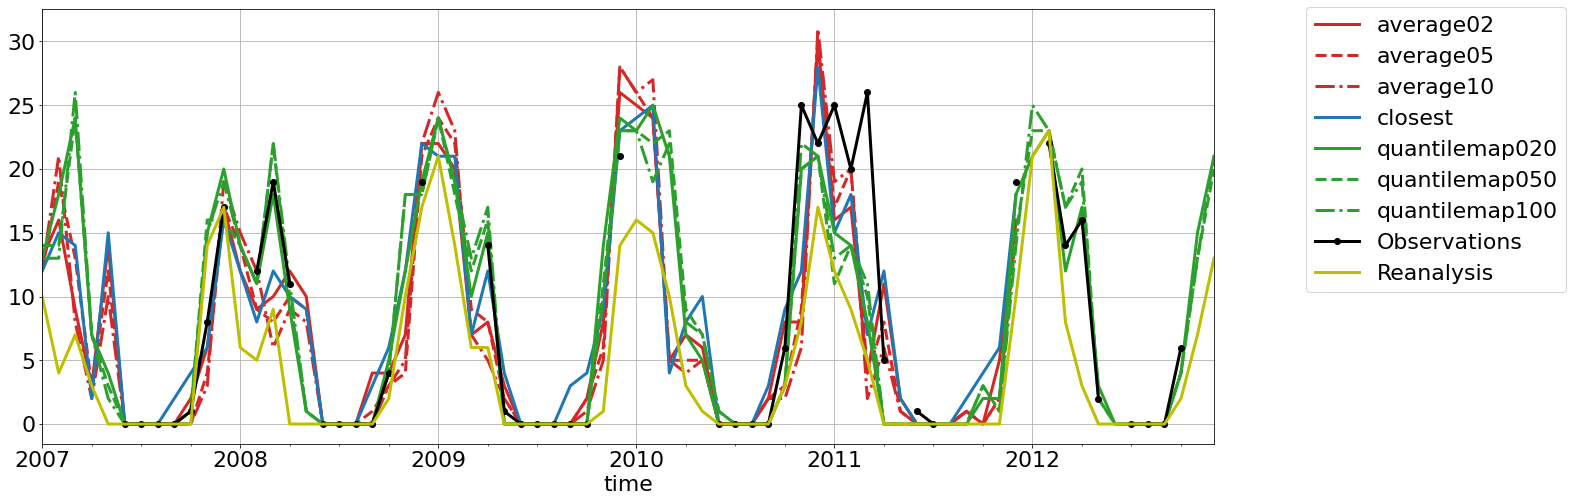

In [34]:
fig, ax = thrskill_1m.plotseries(start=initial_date, end=final_date)

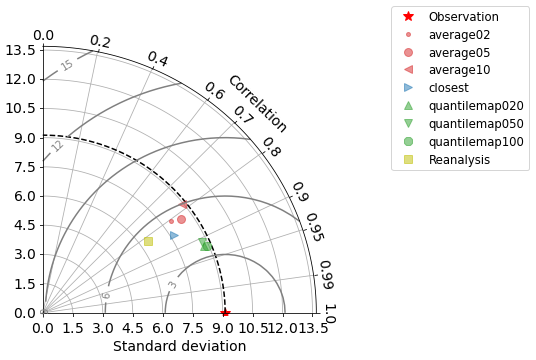

In [35]:
fig, ax = thrskill_1m.taylor()

In [36]:
fig, ax = thrskill_1y.taylor()

ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (0,).

<Figure size 360x360 with 0 Axes>

In [ ]:
best_reconstruction_name = "_".join([variable_to_validate, best_method[station_to_validate]])

station_index = rascal.indices.CIndex(station_daily)
reconstruction_index = rascal.indices.CIndex(reconstructions_daily[best_reconstruction_name].to_frame())

In [ ]:
if variable_to_validate == "TMIN":
    indices = ["fd", "tr"]
    # indices = ["fd", "tr", "tnx", "tnn", "tx10p", "tn90p", "csdi"]
elif variable_to_validate == "TMAX":
    indices = ["su", "id"]
    # indices = ["su", "id", "txx", "txn", "tx10p", "tn90p", "wsdi"]
elif variable_to_validate == "PCP":
    indices = ["rnnmm", "r10mm", "r20mm", "cdd", "cwd", "r95ptot", "r99ptot"]
    # indices = ["rx1day", "rx5day", "sdii", "r10mm", "r20mm", "rnnmm", "cdd", "r95ptot", "r99tot", "prcptot"]

In [ ]:

for idx in indices:
    
    if idx == "rnnmm":
        station_idx_series = station_index.rnnmm(threshold=1)
        reconstruction_idx_series = reconstruction_index.rnnmm(threshold=1)
        
    else:     
        get_station_idx_series = getattr(station_index, idx)
        station_idx_series = get_station_idx_series()
    
        get_reconstruction_idx_series = getattr(reconstruction_index, idx)
        reconstruction_idx_series = get_reconstruction_idx_series()
    
    # Monthly Indices
    if idx in ["cdd", "cwd"]:
        station_idx_series_1m = station_idx_series.resample("1m").max()
        reconstruction_idx_series_1m = reconstruction_idx_series.resample("1m").max()
    else:
        station_idx_series_1m = station_idx_series.resample("1m").sum()
        reconstruction_idx_series_1m = reconstruction_idx_series.resample("1m").sum()
    
    _, idx_1m_skill = rascal.analysis.get_skill(
        simulations=reconstruction_idx_series_1m,
        observation=station_idx_series_1m
    )
        
    station_idx_series_1m.columns = [idx]
    station_idx_series_1m["model"] = "Observations"
    
    reconstruction_idx_series_1m.columns = [idx]
    reconstruction_idx_series_1m["model"] = best_method[station_to_validate]
    
    idx_series_1m = pd.concat([station_idx_series_1m, reconstruction_idx_series_1m], axis=0)
    idx_series_1m["month"] = idx_series_1m.index.month
    idx_series_1m.index.name = "time"
    idx_series_1m = idx_series_1m.dropna() 
    idx_series_1m = idx_series_1m.reset_index()

    
    # Yearly Indices
    if idx in ["cdd", "cwd"]:
        station_idx_series_1y = station_idx_series.resample("1Y").max()
        reconstruction_idx_series_1y = reconstruction_idx_series.resample("1Y").max()
    else:
        station_idx_series_1y = station_idx_series.resample("1Y").sum()
        reconstruction_idx_series_1y = reconstruction_idx_series.resample("1Y").sum()
    
    _, idx_1y_skill = rascal.analysis.get_skill(
        simulations=reconstruction_idx_series_1y,
        observation=station_idx_series_1y
    )
    
    print(idx_1m_skill)

    station_idx_series_1y.columns = [idx]
    station_idx_series_1y["model"] = "observations"
    
    reconstruction_idx_series_1y.columns = [idx]
    reconstruction_idx_series_1y["model"] = best_method[station_to_validate]
    
    idx_series_1y = pd.concat([station_idx_series_1y, reconstruction_idx_series_1y], axis=0)
    idx_series_1y.index.name = "time"

    idx_series_1y = idx_series_1y.reset_index()
    

    # Plot series and seasonal cycle
    # fig = plt.figure(figsize=(16, 5))
    # gs = fig.add_gridspec(1, 3)
    
    fig = plt.figure(figsize=(5, 5))
    ax2=fig.subplots()

    # ax1 = fig.add_subplot(gs[0, :-1])
    # ax2 = fig.add_subplot(gs[0, -1])
    
    # if idx in ["tnx", "txn", "cwd", "cdd"]:
    #    sns.lineplot(data=idx_series_1y.dropna(), x="time", y=idx, ax=ax1, hue="model", marker='o')
    #    legend_title = 'R²=' + str(round(idx_1m_skill["r2"].values[0],2))
    #else:
    #    sns.lineplot(data=idx_series_1y, x="time", y=idx, ax=ax1, hue="model", marker='o')
    #    legend_title = 'R²=' + str(round(idx_1m_skill["r2"].values[0],2))
        
    sns.boxplot(data=idx_series_1m, x="month", y=idx, ax=ax2, hue="model")
    
    #ax1.set_ylabel(index_name[idx])
    ax2.set_ylabel(index_name[idx])    

    #ax1.legend().set_title(legend_title)
    ax2.legend(bbox_to_anchor=[0.55, 1.15], loc="upper center", ncol=2)
    
    #ax1.set_xlim(datetime.datetime(1946, 1, 1), datetime.datetime(2011, 1, 1))
    
    #ax1.grid()
    ax2.grid()
    ax2.set_title("(c)                                                                ")
    #fig.subplots_adjust(wspace=0.4)

    plt.show()
